## Introduction

In this notebook we build and train a deep learning model without using a high-level API library to solve Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition! Your goal is to "use machine learning to create a model that predicts which passengers survived the Titanic shipwreck".

Much of this code is already written for you, but there will also be spots for you to write your own code. It is important that you still read and understand the prewritten code, as it will make writing your own code much easier.

Additionally, there are comments with references to relevant pieces of code that will help you when solving problems. For example, a hint might tell you that the code marked with `(1)` is relevant to the solution. Thus, it is important to read the code and understand it.

In [1]:
!pip install kaggle

In [2]:
creds = '{"username":"zhukevin2020","key":"dc4317bf07a05827b700557e31aca195"}'

In [3]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path = Path('titanic')

In [5]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [6]:
!ls {path}


gender_submission.csv  test.csv  train.csv


In [7]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Data Preprocessing

**IMPORTANT**: You can quickly skim through this part. Don't worry about reading/understanding this part of the notebook until after you have finished and have time to come back to it. However, make sure you still run all of the code in this section.

Once you get to the section titled `Setting up a linear model`, begin reading and understanding the code.

Note: to quickly this section and run all of the code, you can collapse the section by clicking on the arrow next to `Cleaning the data`. Then, make sure you hit the button to run all of the cells.

Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition is a *tabular data* competition -- the data is in the form of a table. It's provided as a Comma Separated Values (CSV) file. We can open it using the *pandas* library, which will create a `DataFrame`.

In [8]:
df = pd.read_csv(f"{path}/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We want to multiply each column by some coefficients. But we can see in the `Cabin` column that there are `NaN` values, which is how Pandas refers to missing values. We can't multiply something by a missing value!

Let's check which columns contain `NaN` values. Pandas' `isna()` function returns `True` (which is treated as `1` when used as a number) for `NaN` values, so we can just add them up for each column:

In [9]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Notice that by default Pandas sums over columns.

We'll need to replace the missing values with something. It doesn't generally matter too much what we choose. We'll use the most common value (the "*mode*"). We can use the `mode` function for that. One wrinkle is that it returns more than one row in the case of ties, so we just grab the first row with `iloc[0]`:

In [10]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

By the way, it's never a good idea to use functions without understanding them. So be sure to google for anything you're not familiar with. E.g if you want to learn about `iloc` (which is a very important function indeed!) then Google will give you a link to a [great tutorial](https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/).

Now that we've got the mode of each column, we can use `fillna` to replace the missing values with the mode of each column. We'll do it "in place" -- meaning that we'll change the dataframe itself, rather than returning a new one.

In [11]:
# Your code here. Use fillna
df = df.fillna(modes)

We can now check there's no missing values left:

In [12]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Here's how we get a quick summary of all the numeric columns in the dataset:

In [13]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that `Fare` contains mainly values of around `0` to `30`, but there's a few really big ones. This is very common with fields contain monetary values, and it can cause problems for our model, because once that column is multiplied by a coefficient later, the few rows with really big values will dominate the result.

You can see the issue most clearly visually by looking at a histogram, which shows a long tail to the right (and don't forget: if you're not entirely sure what a histogram is, Google "[histogram tutorial](https://www.google.com/search?q=histogram+tutorial&oq=histogram+tutorial)" and do a bit of reading before continuing on):

<Axes: >

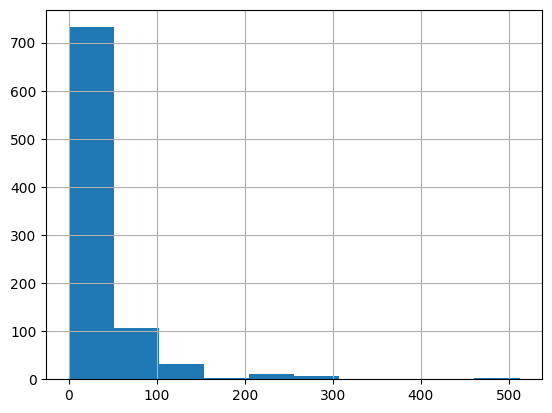

In [14]:
# Your code here. Get a histogram of the Fare column
df["Fare"].hist()

To fix this, the most common approach is to take the logarithm, which squishes the big numbers and makes the distribution more reasonable. Note, however, that there are zeros in the `Fare` column, and `log(0)` is infinite -- to fix this, we'll simply add `1` to all values first:

In [15]:
df['LogFare'] = np.log(df['Fare']+1)

The histogram now shows a more even distribution of values without the long tail:

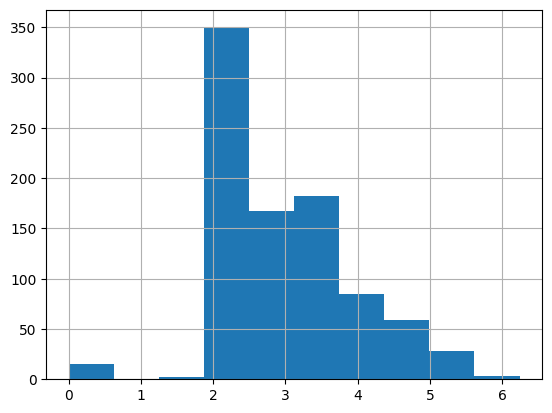

In [16]:
df['LogFare'].hist();

It looks from the `describe()` output like `Pclass` contains just 3 values, which we can confirm by looking at the [Data Dictionary](https://www.kaggle.com/competitions/titanic/data) (which you should always study carefully for any project!) --

In [17]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Here's how we get a quick summary of all the non-numeric columns in the dataset:

In [18]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Clearly we can't multiply strings like `male` or `S` by coefficients, so we need to replace those with numbers.

We do that by creating new columns containing *dummy variables*. A dummy variable is a column that contains a `1` where a particular column contains a particular value, or a `0` otherwise. For instance, we could create a dummy variable for `Sex='male'`, which would be a new column containing `1` for rows where `Sex` is `'male'`, and 0 for rows where it isn't.

Pandas can create these automatically using `get_dummies`, which also remove the original columns. We'll create dummy variables for `Pclass`, even although it's numeric, since the numbers `1`, `2`, and `3` correspond to first, second, and third class cabins - not to counts or measures that make sense to multiply by. We'll also create dummies for `Sex` and `Embarked` since we'll want to use those as predictors in our model. On the other hand, `Cabin`, `Name`, and `Ticket` have too many unique values for it to make sense creating dummy variables for them.

In [19]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

We can see that 5 columns have been added to the end -- one for each of the possible values of each of the three columns we requested, and that those three requested columns have been removed.

Here's what the first few rows of those newly added columns look like:

In [20]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols] = df[added_cols].astype(int)
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Now we can create our independent (predictors) and dependent (target) variables. They both need to be PyTorch tensors. Our dependent variable is `Survived`:

In [21]:
from torch import tensor

t_dep = tensor(df.Survived)

Our independent variables are all the continuous variables of interest plus all the dummy variables we just created:

In [22]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

Here's the number of rows and columns we have for our independent variables:

In [23]:
t_indep.shape

torch.Size([891, 12])

We can see we've got a problem here. When we eventually take the sums of each row, they'll be dominated by the first column, which is `Age`, since that's bigger on average than all the others.

Let's make all the columns contain numbers from `0` to `1`, by dividing each column by its `max()`:

In [24]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

As we see, that removes the problem of one column dominating all the others.

## Setting up a linear model

In language more familiar to us, a linear model is a "neural network" with no hidden layers. In reality, it makes more sense to go from the other direction, viewing a neural network as a composition of linear models.


Now that we've cleaned the data, we can work on calculating our predictions and our loss. In this section, we're going to manually do a single step of calculating predictions and loss for every row of our data.

Our first model will be a simple linear model. We'll need a coefficient for each column in `t_indep`. We'll pick random numbers in the range `(-0.5,0.5)`, and set our manual seed so that my explanations in the prose in this notebook will be consistent with what you see when you run it.

Note: t_indep is named after "independent tensor", for an independent variable, which is another terminology for just an input or X variable.

coeffs, or "coefficients" are another word for weights or parameters.

In [107]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [108]:
t_indep.shape

torch.Size([891, 12])

Our predictions will be calculated by multiplying each row by the coefficients, and adding them up. For now, don't worry about a bias term, although note that most, if not all, models do use a constant term.

Here's what the multiplication looks like:

In [109]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [110]:
preds = (t_indep*coeffs).sum(axis=1) # 1

Let's take a look at the first few:

In [111]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

Of course, these predictions aren't going to be any use, since our coefficients are random -- they're just a starting point for our gradient descent process.

To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [112]:
loss = torch.abs(preds-t_dep).mean() # (2)
loss

tensor(0.5382)

Now that we've tested out a way of calculating predictions, and loss, let's pop them into functions to make life easier:

For documentation on torch.sum, look [here](https://pytorch.org/docs/stable/generated/torch.sum.html).

In [113]:
# TODO: Complete the following functions: calc_preds, calc_loss
# note that each function should only require one line to complete
# carefully read the above material for hints on how to accomplish this task

def calc_preds(coeffs, indeps): return torch.sum(indeps*coeffs, axis=1) # Your code here - hint: look at the code above marked with (1), hint: use torch.sum(___, axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean() # Your code here - hint: look at the code above marked with (2)

Before you move on, run the following cell to test your code.

In [114]:
t_dep = tensor(df.Survived)
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
torch.manual_seed(348)
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
calc_loss(coeffs, t_indep, t_dep).item()

if abs(calc_loss(coeffs, t_indep, t_dep).item() - 0.624920666) < 1e-8:
  print("Test passed: calc_preds and calc_loss were successfully implemented.")
else:
  print("Test failed: take a look at calc_preds and calc_loss again.")

Test passed: calc_preds and calc_loss were successfully implemented.


## Doing a gradient descent step

In this section, we're going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients, because let's face it that's pretty tedious and entirely pointless to do by hand! To get PyTorch to calculate gradients, we'll need to call `requires_grad_()` on our `coeffs`:

In [115]:
coeffs.requires_grad_()

tensor([ 0.3516, -0.1277, -0.1233, -0.1802,  0.4763, -0.1150, -0.2591,  0.1507, -0.2457,  0.0565, -0.0852,  0.0070], requires_grad=True)

Now when we calculate our loss, PyTorch will keep track of all the steps, so we'll be able to get the gradients afterwards:

In [116]:
loss = calc_loss(coeffs, t_indep, t_dep) # Your code here - hint: use a function you've already written
loss

tensor(0.6249, grad_fn=<MeanBackward0>)

Use `backward()` to ask PyTorch to calculate gradients now:

In [117]:
loss.backward()

Let's see what they look like:

In [118]:
coeffs.grad

tensor([ 0.0405, -0.0112, -0.0284, -0.0228,  0.3939, -0.3389, -0.0696,  0.0112,  0.1134, -0.0404, -0.0101,  0.1055])

Note that each time we call `backward`, the gradients are actually *added* to whatever is in the `.grad` attribute. Let's try running the above steps again:

In [119]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.0810, -0.0224, -0.0569, -0.0457,  0.7879, -0.6779, -0.1392,  0.0224,  0.2267, -0.0808, -0.0202,  0.2110])

As you see, our `.grad` values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.

We can now do one gradient descent step, and check that our loss decreases:

In [120]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1) # (3)
    coeffs.grad.zero_() # (3)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5386)


Note that `a.sub_(b)` subtracts `b` from `a` in-place. In PyTorch, any method that ends in `_` changes its object in-place. Similarly, `a.zero_()` sets all elements of a tensor to zero.

## Training the linear model

Before we begin training our model, we'll need to ensure that we hold out a validation set for calculating our metrics.

There's lots of different ways we can do this. Let's use `RandomSplitter` to get indices that will split our data into training and validation sets:

In [121]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

Now we can apply those indicies to our independent and dependent variables:

In [122]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
print(len(trn_indep),len(val_indep))
print(len(trn_dep),len(val_dep))

713 178
713 178


We'll create functions for the three things we did manually above: updating `coeffs`, doing one full gradient descent step, and initilising `coeffs` to random numbers:

In [123]:
def update_coeffs(coeffs, lr):
    # Your code here - hint: look at the code marked above with (3), hint: remember to use your learning rate, hint: ~2 lines needed
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [124]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [125]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

We can now use these functions to train our model:

In [126]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs() # Your code here - hint: what function do we have that initializes coeffs?
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

Let's try it. Our loss will print at the end of every step, so we hope we'll see it going down:

In [127]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

It does!

Let's take a look at the coefficients for each column:

In [128]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## Measuring accuracy

The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by *accuracy* -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [129]:
preds = calc_preds(coeffs, val_indep) # (4)

We'll assume that any passenger with a score of over `0.5` is predicted to survive. So that means we're correct for each row where `preds>0.5` is the same as the dependent variable:

In [130]:
results = val_dep.bool()==(preds>0.5) # (4)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

Let's see what our average accuracy is:

In [131]:
results.float().mean() # (4)

tensor(0.7865)

That's not a bad start at all! We'll create a function so we can calcuate the accuracy easy for other models we train:

In [132]:
def acc(coeffs):
  # Your code here - hint: look at the code marked above with (4)
  return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

## Using sigmoid

Looking at our predictions, there's one obvious problem -- some of our predictions of the probability of survival are `>1`, and some are `<0`:

In [133]:
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

To fix this, we should pass every prediction through the *sigmoid function*, which has a minimum at zero and maximum at one, and is defined as follows:

$$s(x)=\frac{1}{1+e^{-x}}$$

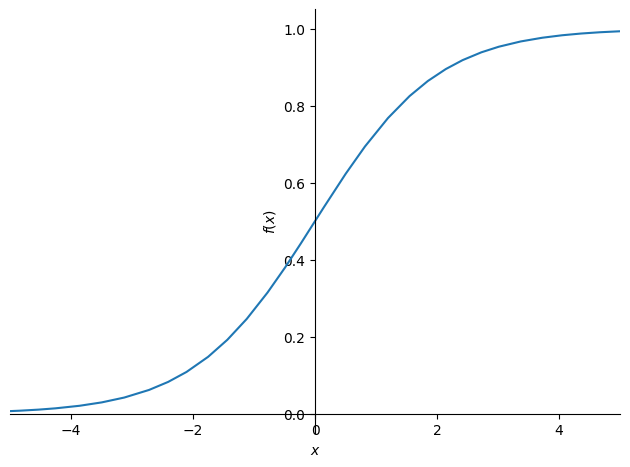

In [134]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

PyTorch already defines that function for us, so we can modify `calc_preds` to use it:

You may see the PyTorch documentation on torch.sigmoid [here](https://pytorch.org/docs/stable/generated/torch.sigmoid.html).

In [135]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1)) # Your code here - hint: apply torch.sigmoid on what the previous calc_preds returned

Let's train a new model now, using this updated function to calculate predictions:

In [136]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

The loss has improved by a lot. Let's check the accuracy:

In [137]:
acc(coeffs)

tensor(0.8258)

That's improved too! Here's the coefficients of our trained model:

In [138]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

Do these coefficients seem reasonable? -- Why or why not?

## Submitting to Kaggle

**IMPORTANT:** You may skip this section. Later on, it will be useful to learn about Kaggle and how to participate in competitions, but for now, complete the rest of the notebook.

Now that we've got a trained model, we can prepare a submission to Kaggle. To do that, first we need to read the test set:

In [99]:
tst_df = pd.read_csv(path/'test.csv')
tst_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In this case, it turns out that the test set is missing `Fare` for one passenger. We'll just fill it with `0` to avoid problems:

In [100]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

Now we can just copy the same steps we did to our training set, in the `Cleaning the data` section, and do the same exact things on our test set to preprocess the data:

In [101]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

# NOTE: One-Hot Encoding
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
tst_df[added_cols] = tst_df[added_cols].astype(int)
tst_df[added_cols].head()

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

tst_df.describe(include=[object])

,Name,Ticket,Cabin
count,418,418,418
unique,418,363,77
top,"Kelly, Mr. James",PC 17608,B96 B98
freq,1,5,327


Let's calculate our predictions of which passengers survived in the test set:

In [139]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

The sample submission on the Kaggle competition site shows that we're expected to upload a CSV with just `PassengerId` and `Survived`, so let's create that and save it:

In [140]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

We can check the first few rows of the file to make sure it looks reasonable:

In [141]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [142]:
df[indep_cols]

,Age,SibSp,Parch,LogFare,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,2.110213,1,0,0,0,1,0,0,1
1,38.0,1,0,4.280593,0,1,1,0,0,1,0,0
2,26.0,0,0,2.188856,0,1,0,0,1,0,0,1
3,35.0,1,0,3.990834,0,1,1,0,0,0,0,1
4,35.0,0,0,2.202765,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,2.639057,1,0,0,1,0,0,0,1
887,19.0,0,0,3.433987,0,1,1,0,0,0,0,1
888,24.0,1,2,3.196630,0,1,0,0,1,0,0,1
889,26.0,0,0,3.433987,1,0,1,0,0,1,0,0


In [143]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression(max_iter=1000)
lr.fit(df[indep_cols], df['Survived'])

# predictions = lr.predict(tst_df[indep_cols])

# tst_df['Survived'] = (predictions[:,1]>0.5).int()

# Use predict_proba to get probabilities for each class
probabilities = lr.predict_proba(tst_df[indep_cols])

# The second column gives the predicted probability of the positive class
tst_df['Survived'] = (probabilities[:,1] > 0.5).astype(int)


sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sublr.csv', index=False)

In [144]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df[indep_cols], df['Survived'])

probabilities = rf.predict_proba(tst_df[indep_cols])

# The second column gives the predicted probability of the positive class
tst_df['Survived'] = (probabilities[:,1] > 0.5).astype(int)


sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('subrf2.csv', index=False)

In [145]:
tst_df['Survived']

0      0
1      0
2      0
3      1
4      0
      ..
413    0
414    1
415    0
416    0
417    1
Name: Survived, Length: 418, dtype: int64

When you click "save version" in Kaggle, and wait for the notebook to run, you'll see that `sub.csv` appears in the "Data" tab. Clicking on that file will show a *Submit* button, which allows you to submit to the competition.

## Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [146]:
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the `@` operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [147]:
val_indep@coeffs # (5)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

Let's use this to replace how `calc_preds` works:

In [148]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs) # Your code here - hint: look at the code marked above with (5), hint: remember to use the activation function

In order to do matrix-matrix products (which we'll need in the next section), we need to turn `coeffs` into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument `1` to `torch.rand()`, indicating that we want our coefficients to have one column:

In [149]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value `None`, which tells PyTorch to add a new dimension in this position:

In [150]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

We can now train our model as before and confirm we get identical outputs...:

In [151]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

...and identical accuracy:

In [152]:
acc(coeffs)

tensor(0.8258)

## A neural network

We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our `n_coeff` inputs, and create `n_hidden` outputs. We can choose whatever `n_hidden` we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size `n_coeff` by `n_hidden`. We'll divide these coefficients by `n_hidden` so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the `n_hidden` inputs and create a single output, so that means we need a `n_hidden` by `1` matrix there. The second layer will also need a constant term added.

In [60]:
def init_coeffs(n_hidden=20): # (6)
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, `indeps@l1` and `res@l2` (where `res` is the output of the first layer). The first layer output is passed to `F.relu` (that's our non-linearity), and the second is passed to `torch.sigmoid` as before.

In [61]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps): # (7)
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

See relevant documentation on sub [here](https://pytorch.org/docs/stable/generated/torch.sub.html#torch.sub).

In [62]:
def update_coeffs(coeffs, lr): # (8)
    for layer in coeffs:
        layer.sub_(layer.grad * lr) # Your code here - hint: ~2 lines needed, hint: recall the structure of the first update_coeffs function you wrote, now it is being applied to each layer!
        layer.grad.zero_()

That's it -- we're now ready to train our model!

In [63]:
coeffs = train_model(lr=1.4)

0.544; 0.538; 0.532; 0.526; 0.519; 0.512; 0.504; 0.495; 0.486; 0.476; 0.465; 0.455; 0.444; 0.434; 0.426; 0.418; 0.412; 0.407; 0.403; 0.400; 0.397; 0.395; 0.393; 0.391; 0.390; 0.389; 0.388; 0.387; 0.387; 0.386; 

In [64]:
coeffs = train_model(lr=5)

0.544; 0.524; 0.499; 0.468; 0.434; 0.408; 0.396; 0.390; 0.386; 0.385; 0.383; 0.383; 0.382; 0.382; 0.381; 0.381; 0.381; 0.381; 0.380; 0.380; 0.380; 0.380; 0.380; 0.380; 0.380; 0.380; 0.380; 0.380; 0.380; 0.379; 

It's looking good -- our loss is lower than before. Let's see if that translates to a better result on the validation set:

In [65]:
acc(coeffs)

tensor(0.5955)

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## Deep learning

The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

In [66]:
def init_coeffs():
    # Your code here - hint: look at the code marked above with a (6)
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot of messy constants to get the random numbers in just the right ranges. When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients. Nowadays, we have ways to deal with that, which we'll learn about in other notebooks.

Our deep learning `calc_preds` looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [67]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    # Your code here - hint: look at the code marked above with a (7)
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

We also need a minor update to `update_coeffs` since we've got `layers` and `consts` separated now:

In [68]:
def update_coeffs(coeffs, lr):
    # Your code here - hint: look at the code marked above with a (8)
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Let's train our model...

In [69]:
coeffs = train_model(lr=4)

lrs = [0.001, 0.1, 1, 3, 5, 10, 20, 100, 1000]

for lr in lrs:
  coeffs = train_model(epochs = 200, lr=lr)
  accuracy = acc(coeffs)
  print("accuracy: ", lr, accuracy)

# coeffs
coeffs = train_model(lr=1)

0.531; 0.484; 0.470; 0.457; 0.447; 0.437; 0.430; 0.424; 0.419; 0.414; 0.411; 0.408; 0.405; 0.403; 0.401; 0.400; 0.398; 0.397; 0.396; 0.395; 0.394; 0.393; 0.392; 0.392; 0.391; 0.391; 0.390; 0.390; 0.389; 0.389; 0.531; 0.531; 0.531; 0.531; 0.531; 0.531; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.530; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.529; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.528; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.527; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.526; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.525; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.524; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.523; 0.522; 0.522; 0.522; 0.522; 0.522; 0.522;

...and check its accuracy:

In [70]:
acc(coeffs)

tensor(0.5955)

In [153]:
tst_df['Survived'] = (calc_preds(coeffs, tst_indep)>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub_nn.csv', index=False)

In [154]:
sub_df.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## Logistic Regression

**Logistic regression** is a popular statistical technique used for **binary classification tasks**. It is a type of **supervised learning** algorithm that predicts the probability of an instance belonging to a particular class.

In logistic regression, the input features are combined linearly, and the result is passed through the logistic function (sigmoid) to produce an output value between $0$ and $1$, representing the probability of the instance belonging to the positive class. If the probability is greater than a predefined threshold (usually $0.5$), the instance is classified as the positive class; otherwise, it is classified as the negative class.

Logistic regression is widely used in various fields, including medical diagnosis, finance, and marketing, where the goal is to make binary decisions based on input features. Here, we will use it on our Titanic dataset to determine which passengers were more likely to survive.


If you are interested in an explanation of the math, then the following is an explanation of the equations used in logistic regression. Don't worry too much about understanding this as it is not mandatory to writing the code. You can skip straight to the code section if you please.

Recall the sigmoid function, which is defined as follows:

$$s(x)=\frac{1}{1+e^{-x}}$$

In logistic regression, we apply the sigmoid function on $\theta^\mathsf{T}x$, the dot product of $\theta$ and $x$, to get the output probability (note that here $\theta$ denotes our parameters). That is, we make a prediction for $x$ according to the following:

$$h_{\theta}(x)=s(\theta^\mathsf{T}x)=\frac{1}{1+e^{-\theta^\mathsf{T}x}}$$

We use the following function, known as the logistic loss function:

 $$J(\theta)=-\frac{1}{m}\sum_{i=1}^m\left[y^{(i)}\log(h_{\theta}(x^{(i)}))+(1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))\right],$$

where $x^{(i)}$, $y^{(i)}$ denote the data and value of training point $i$. Use gradient descent to update the parameters as shown below:

$$\theta_j\leftarrow \theta_j - \alpha\cdot\frac{∂ J(\theta)}{∂ \theta_j}$$




The following is an image depicting an example of logistic regression being using on a two dimensional dataset to distinguish between "True samples" and "False samples".

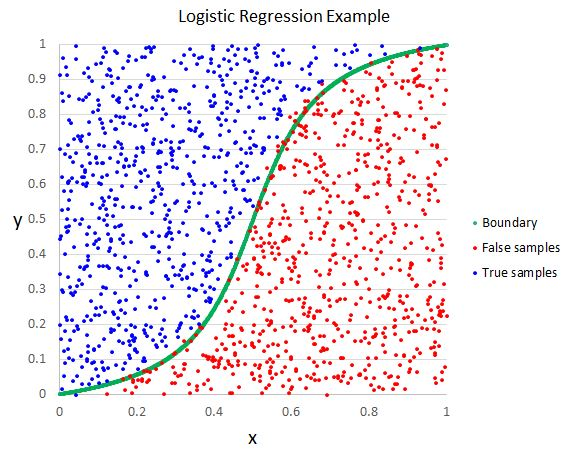

First, we'll import the necessary modules from `sklearn`.

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Next, we want to initialize our model. Look at the following `sklearn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for insight into how to initialize a logistic regression model. Note that oftentimes looking at examples towards the bottom can be useful.

Here `clf` is shorthand for "classifier".

In [161]:
clf = LogisticRegression(random_state=42, max_iter=100)

We need to use our data to train the model. Let's recall what we have.
- `trn_indep` is $x$ as explained from above
- `trn_dep` is $y$ as explained from above
- $\theta$ as explained from above is the parameters our model uses, that we will learn

Note: `trn_dep.ravel()` is used below in place of `trn_dep` due to some errors that can sometimes occur in the shape of `y_train`.

`.ravel()` converts it to a 1-d array, but the details are not important for now.

In [162]:
X_train = trn_indep
y_train = trn_dep.ravel()

We can verify the shapes of `X_train` and `y_train` match up by printing them.

In [163]:
print("The shape of X_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)

The shape of X_train is: torch.Size([713, 12])
The shape of y_train is: torch.Size([713])


Again, look at the documentation linked above for how to *fit* a classifier using `sklearn`.

In [167]:
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

Now let's measure our accuracy. Recall that we previously used the following variables to test our previous models.
- `val_indep`
- `val_dep`

In [168]:
X_test = val_indep
y_test = val_dep.ravel()

Now that we have our test data, let's measure the accuracy of our model. Look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for `sklearns`'s `accuracy_score` function. Look at what its inputs are, and think about how we can get them in order to pass them in.

Hint: also look at the `predict` method in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) by doing a keyword search.

In [170]:
from sklearn.metrics import mean_squared_error

# Your code here
y_pred = clf.predict(X_test)
accuracy = mean_squared_error(y_test, y_pred)

In [171]:
print("Accuracy achieved with a Logistic Regression model:", accuracy)

Accuracy achieved with a Logistic Regression model: 0.19101123595505617


## Random Forest

The next model is quite different from anything you've learned so far. A **random forest** is an **ensemble learning method** used for both classification and regression tasks. It is based on the concept of bagging, which stands for [Bootstrap Aggregating](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/). The main idea behind a random forest is to combine the predictions of multiple individual **decision trees** to achieve more accurate and robust results.

That's a lot of new terms! Let's break it down at a high level:
- ensemble learning: a machine learning technique that combines the predictions of multiple individual models to produce a more accurate and robust final prediction
- a tree-like model that makes decisions based on a series of binary splits on the input features. Each internal node of the tree represents a decision based on a specific feature, and each leaf node represents the final prediction for a given input

Here is a visualization of a simple decision tree that predicts whether or not a golfer will be above or below par.

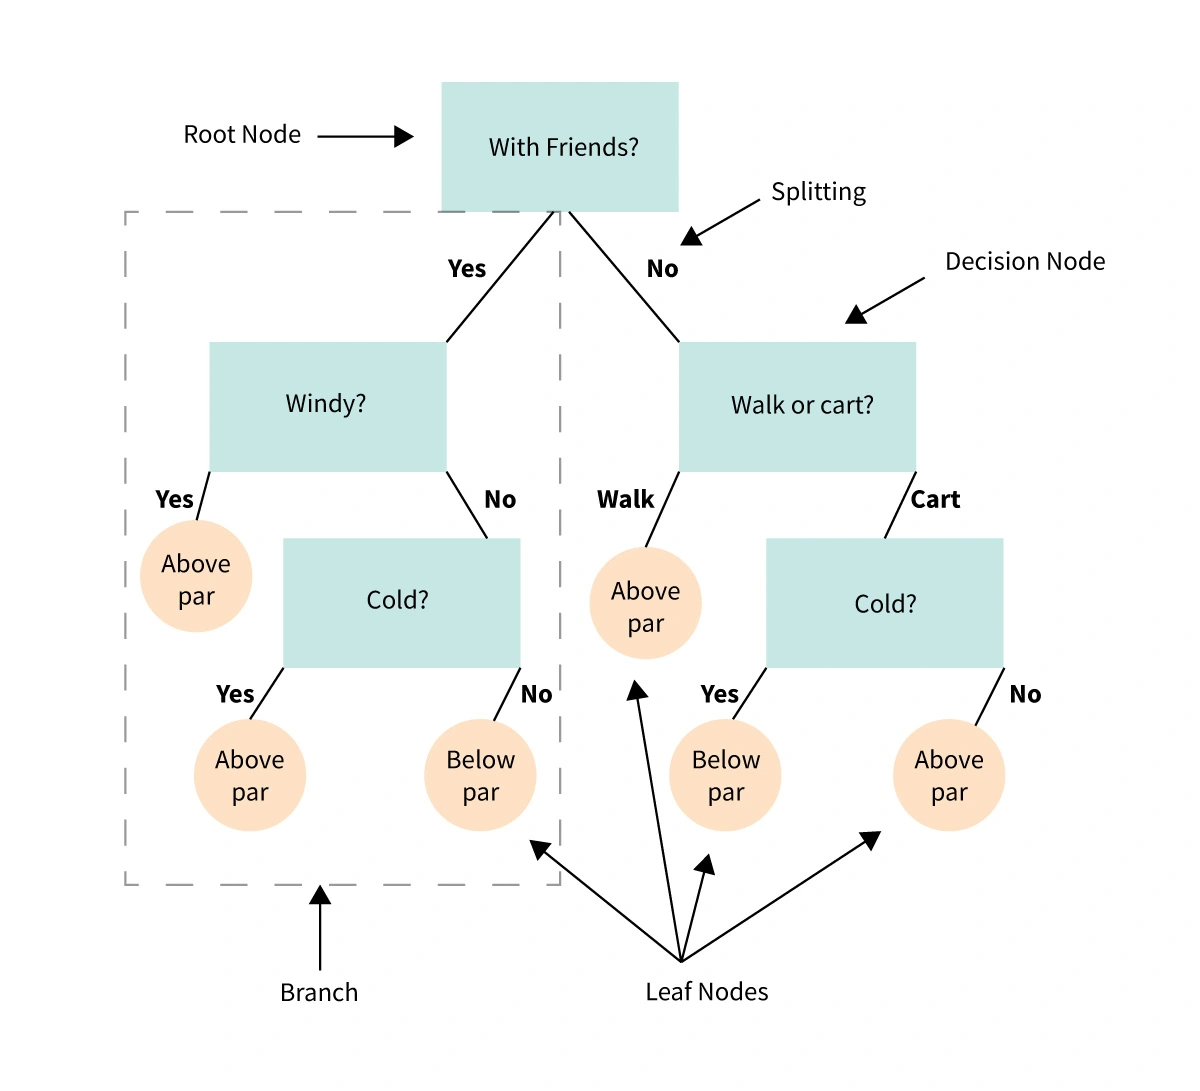

A random forest can be thought of as just aggregating many different decision trees in order to perform classification / regression.

Let's use `sklearn` to build a random forest to solve our Titanic problem. As in the logistic regression section, let's import the required functions and recall our data.

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X_train = trn_indep
y_train = trn_dep.ravel()
X_test = val_indep
y_test = val_dep.ravel()

Define a random forest classifer. Take a look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Just as you did with logistic regression, fit your classifier to the training data.

In [175]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Now, measure the accuracy of your random forest classifier. Recall what we did with logistic regression if you get stuck.

In [177]:
# Your code here
y_pred = clf.predict(X_test)
accuracy = mean_squared_error(y_test, y_pred)
print(accuracy)

0.1797752808988764


Now, let's perform hyperparameter search using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Use 5-fold cross validation for each of the searches.

1. Search `n_estimators` over $[50, 100, 150, 200]$.
2. Search `max_depth` over $[2, 4, 6, 8, 10]$.
3. Search both `n_estimators` and `max_depth` simulatenously over $[50, 100, 150, 200]$ and $[2, 4, 6, 8, 10]$ respectively.

In [178]:
# 1
model = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 150, 200]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_params_['n_estimators']
print("Best n_estimators:", best_n_estimators)

Best n_estimators: 50


In [179]:
# 2
model = RandomForestClassifier()
param_grid = {'max_depth': [2, 4, 6, 8, 10]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']
print("Best max_depth:", best_max_depth)

Best max_depth: 10


In [180]:
# 3
model = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
print("Best n_estimators:", best_n_estimators)
print("Best max_depth:", best_max_depth)

Best n_estimators: 50
Best max_depth: 4


In [181]:
# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the accuracy of the best model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model:", accuracy)

Accuracy of the best model: 0.8258426966292135


In [182]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[97  9]
 [22 50]]


## Final thoughts and Feedback

Let's recap what we've done so far:
- Deep Neural Network
  - managed to create a real deep learning model from scratch and trained it to get over 80% accuracy on this task
  - "real" deep learning models that are used in research and industry look very similar to this
  - if you look inside the source code of any deep learning model you'll recognise the basic steps are the same
- Logistic Regression
  - built a logistic regression classifier model using sklearn
  - used it to model the Titanic dataset
- Random Forests
  - built a random forest classifier model using sklearn
  - used it to model the Titanic dataset
  - explored the relationship between the number of decision trees and test accuracy
  - explored the relationship between the max depth of decision trees and test accuracy

Citations: Jeremy Howard, Kaggle. Ryan Campbell, Thomas Lu, Kevin Zhu, Algoverse